# Imports

In [1]:
import math
import random as rnd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter

# 2D setup 

In [2]:
DEVICE = torch.device('cpu')

# Data

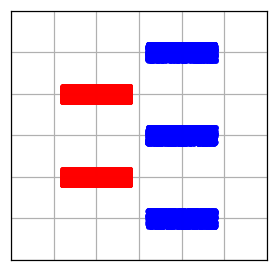

In [3]:
def plot_data(ax, X1, X2):
  ax.plot(X2[:,0], X2[:,1], 'ob', alpha=0.99, markersize=2, rasterized=True)
  ax.plot(X1[:,0], X1[:,1], 'or', alpha=0.99, markersize=2, rasterized=True)
  ax.set_xlim((-3,3))
  ax.set_ylim((-3,3))
  ax.xaxis.set_major_formatter(NullFormatter()) 
  ax.yaxis.set_major_formatter(NullFormatter()) 
  ax.grid(True)
  ax.set_xticks([-3,-2,-1,0,1,2,3])
  ax.set_yticks([-3,-2,-1,0,1,2,3])
  ax.tick_params(axis=u'both', which=u'both',length=0)
  return ax


def generate_dataset():
  data, lbls = [], []
  for _ in range(50000):
    lbl = rnd.random() > 0.5
    if lbl:
      slab = rnd.randint(0,2)
      mean_y = slab * 2 - 2
      mean_x = 1
      data.append([(rnd.random() - 0.5)*1.6 + mean_x, rnd.random()*0.4-0.2 + mean_y])
      lbls.append(1)
    else:
      slab = rnd.randint(0,1)
      mean_y = slab * 2 - 1
      mean_x = -1
      data.append([(rnd.random() - 0.5)*1.6 + mean_x, rnd.random()*0.4-0.2 + mean_y])
      lbls.append(0)
  return np.array(data, dtype=np.float32), np.array(lbls, dtype=np.float32)

X, Y = generate_dataset()

fig, (ax) = plt.subplots(1,1,figsize=(3,3), dpi=110)
X1 = X[Y==0]
X2 = X[Y==1]
ax = plot_data(ax, X1, X2)

# Visualization utils

In [4]:
def plot_decision_boundary_sigmoid(ax, m, min_val=-3, max_val=3):
  x1grid = np.arange(min_val, max_val, 0.02)
  x2grid = np.arange(min_val, max_val, 0.02)
  xx, yy = np.meshgrid(x1grid, x2grid)
  r1, r2 = xx.flatten(), yy.flatten()
  r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
  grid = np.hstack((r1,r2))
  grid = torch.tensor(grid).float().to(DEVICE)
  with torch.no_grad():
    probas = torch.sigmoid(m(grid)).cpu()
  zz = probas.reshape(xx.shape).numpy()
  cs = ax.contourf(xx, yy, zz*0.8+0.1, cmap='RdBu', levels=np.linspace(0, 1, 100))
  for c in cs.collections: # for rasterization
    c.set_rasterized(True)
  return ax


def plot_x_tilde(ax, X_tilde, Y):
  X2 = X_tilde[Y[:,0]==1]
  X1 = X_tilde[Y[:,0]==0]
  ax.plot(X2[:,0], X2[:,1], 'xb', alpha=0.7, markersize=2, rasterized=True)
  ax.plot(X1[:,0], X1[:,1], 'xr', alpha=0.7, markersize=2, rasterized=True)
  return ax

# Training utils

In [5]:
def find_perturbation(X, y, model_1, model_2, eps, alpha, iters, clamp_val=None, rs=True, use_grad_sign=False, normalize_grad=False):
  delta = torch.zeros_like(X).to(X.device)
  if rs:
    delta.uniform_(-eps, eps)

  delta.requires_grad = True
  for _ in range(iters):
    delta.grad = None
    if clamp_val is not None:
      X_ = torch.clamp(X + delta, clamp_val[0], clamp_val[1])
    else:
      X_ = X + delta
    p_1 = torch.sigmoid(model_1(X_))
    p_2 = torch.sigmoid(model_2(X_))
    loss = ( (1.-p_1) * p_2 + p_1 * (1.-p_2)).log().mean()

    loss.backward()
    grad = delta.grad.detach()

    if normalize_grad:
      grad /= grad.norm()

    if use_grad_sign:
      grad = grad.sign()

    delta.data = (delta + alpha * grad)
    if clamp_val is not None:
      delta.data = torch.clamp(X + delta.data, clamp_val[0], clamp_val[1]) - X
    delta.data = torch.clamp(delta.data, -eps, eps)

  return delta.detach()


@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    acc.append((torch.sigmoid(model(X)) > 0.5) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()

# Training the first model

In [6]:
model_1 = nn.Sequential(nn.Linear(2,128), nn.LeakyReLU(), nn.Linear(128,1)) 

opt = torch.optim.Adam(model_1.parameters(), lr=0.01)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X).view(-1,2), torch.tensor(Y).view(-1,1))

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)

stats = {'erm_m1': [], 'erm_m2': [], 'adv_loss': []}

for epoch in range(8):
  for itr, (x, y) in enumerate(train_dl):

    erm_m1 = F.binary_cross_entropy_with_logits(model_1(x), y)
    stats['erm_m1'].append((itr + epoch * len(train_dl), erm_m1.item()))
    erm_loss = erm_m1 # ERM

    loss = erm_loss 

    opt.zero_grad()
    loss.backward()
    opt.step()

# Training the second model

0 -	 [train] loss: 0.71 [m1] acc: 1.00 [m2] acc: 0.84 


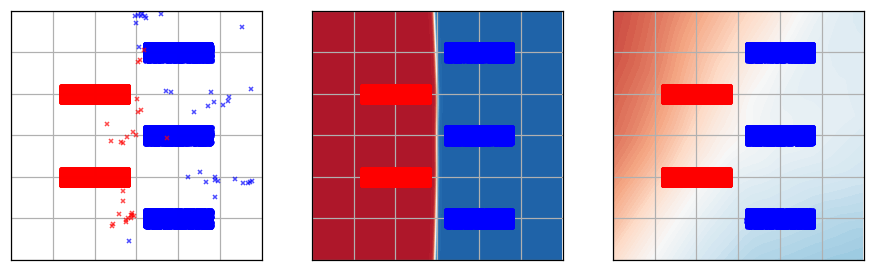

200 -	 [train] loss: 0.03 [m1] acc: 1.00 [m2] acc: 1.00 


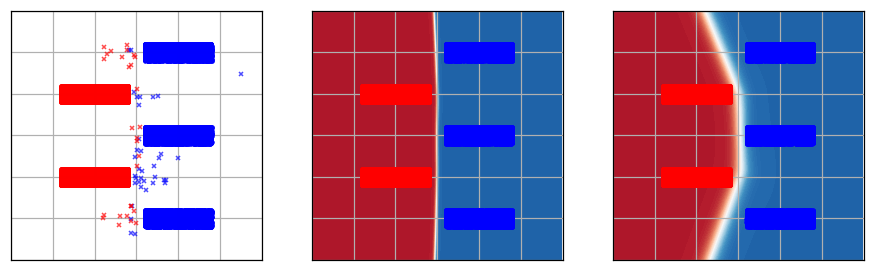

400 -	 [train] loss: 0.02 [m1] acc: 1.00 [m2] acc: 1.00 


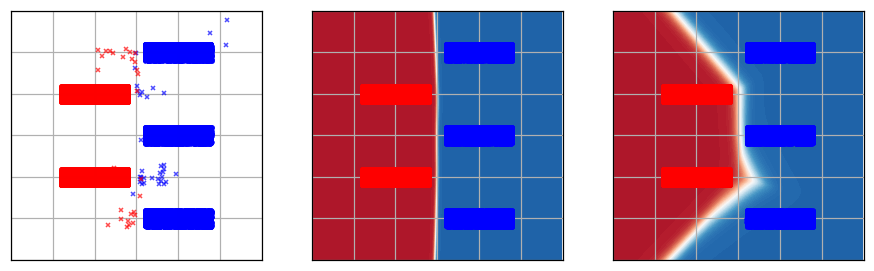

600 -	 [train] loss: 0.01 [m1] acc: 1.00 [m2] acc: 1.00 


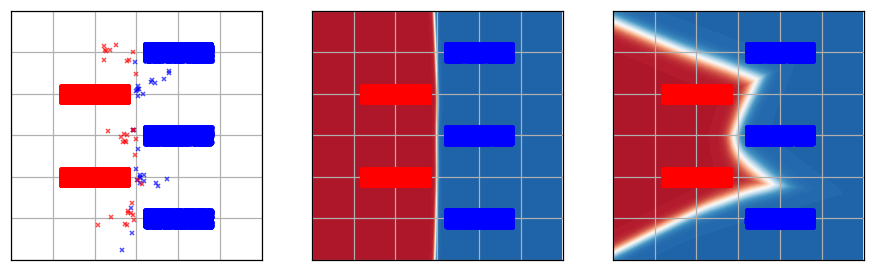

800 -	 [train] loss: 0.02 [m1] acc: 1.00 [m2] acc: 1.00 


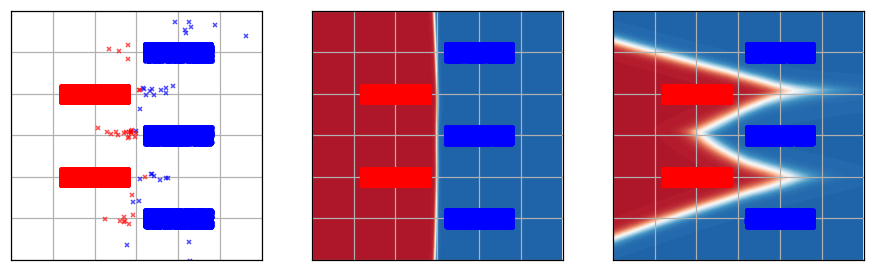

1000 -	 [train] loss: 0.01 [m1] acc: 1.00 [m2] acc: 1.00 


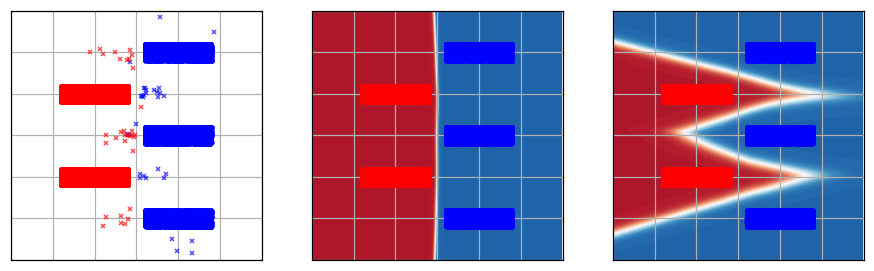

1200 -	 [train] loss: 0.02 [m1] acc: 1.00 [m2] acc: 1.00 


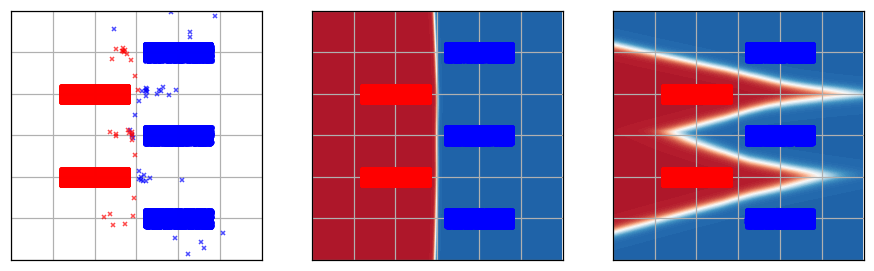

1400 -	 [train] loss: 0.01 [m1] acc: 1.00 [m2] acc: 1.00 


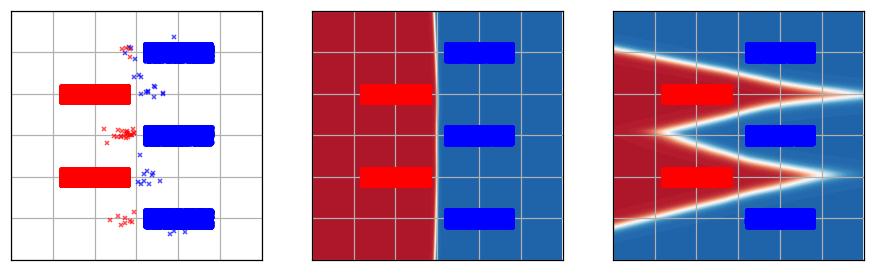

1600 -	 [train] loss: 0.01 [m1] acc: 1.00 [m2] acc: 1.00 


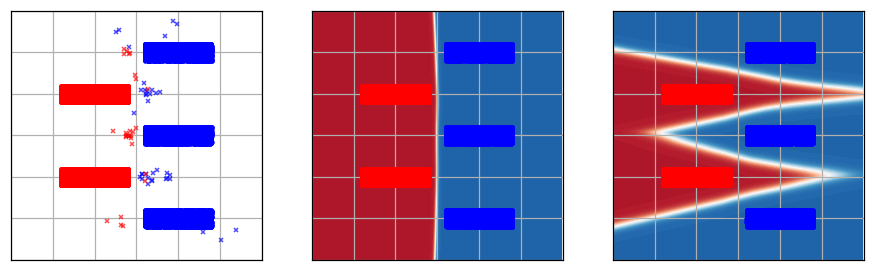

1800 -	 [train] loss: 0.01 [m1] acc: 1.00 [m2] acc: 1.00 


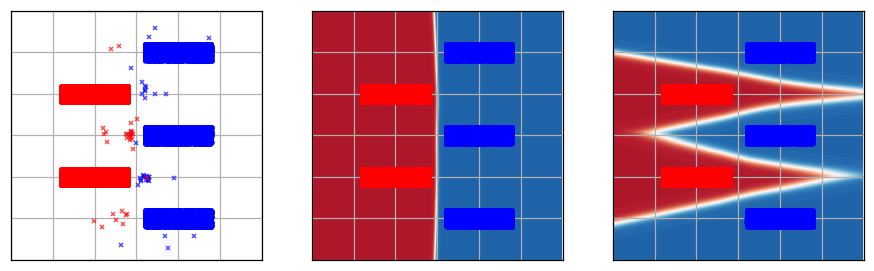

2000 -	 [train] loss: 0.02 [m1] acc: 1.00 [m2] acc: 1.00 


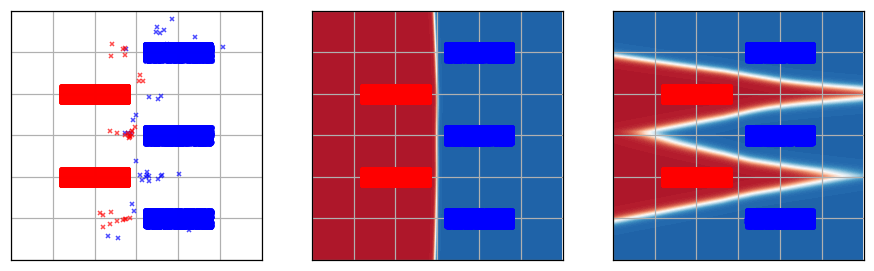

2200 -	 [train] loss: 0.02 [m1] acc: 1.00 [m2] acc: 1.00 


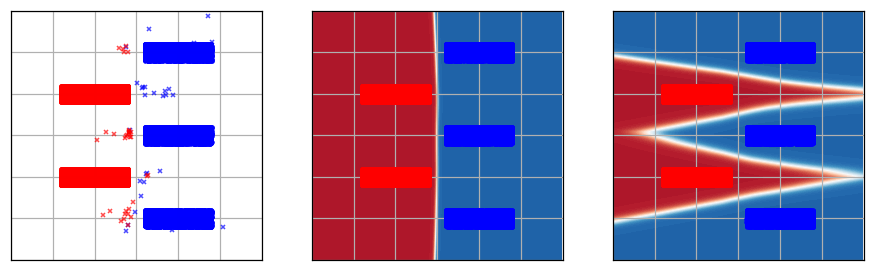

2400 -	 [train] loss: 0.01 [m1] acc: 1.00 [m2] acc: 1.00 


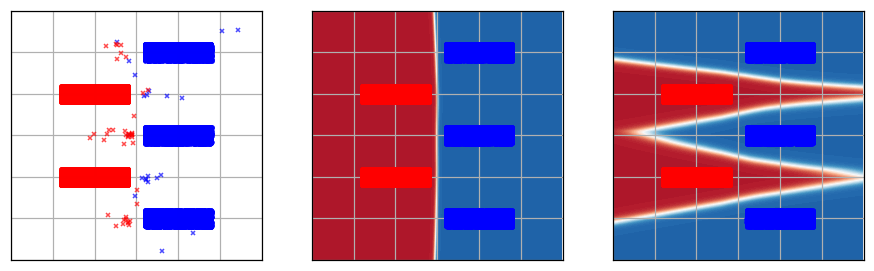

2600 -	 [train] loss: 0.02 [m1] acc: 1.00 [m2] acc: 1.00 


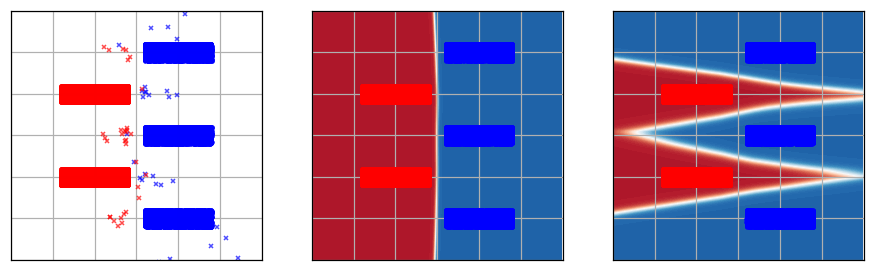

2800 -	 [train] loss: 0.01 [m1] acc: 1.00 [m2] acc: 1.00 


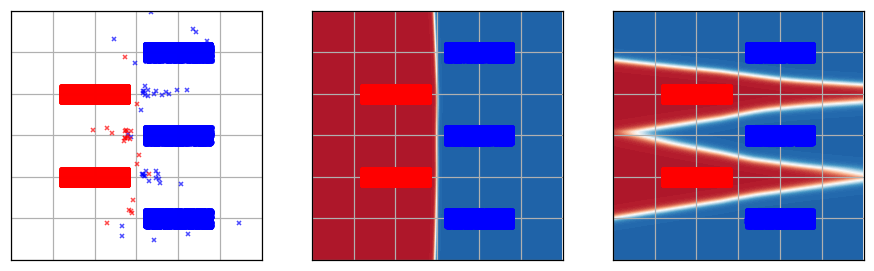

3000 -	 [train] loss: 0.02 [m1] acc: 1.00 [m2] acc: 1.00 


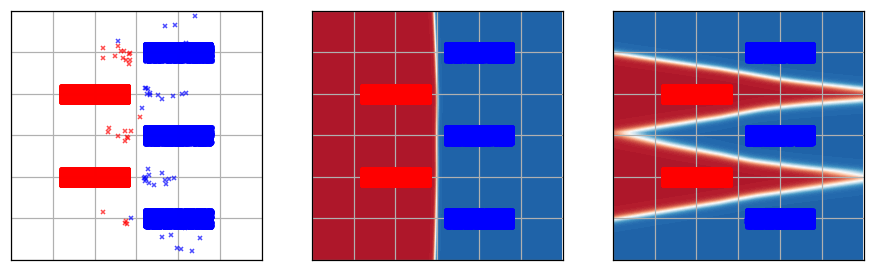

In [14]:
ALPHA = 0.01

model_2 = nn.Sequential(nn.Linear(2,128), nn.LeakyReLU(), nn.Linear(128,1)) 

opt = torch.optim.Adam(model_2.parameters(), lr=0.01)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X).view(-1,2), torch.tensor(Y).view(-1,1))

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(4):
  for itr, (x, y) in enumerate(train_dl):

    erm_loss = F.binary_cross_entropy_with_logits(model_2(x), y)

    delta = find_perturbation(x, y, model_1, model_2, eps=1.0, alpha=0.1, iters=15, use_grad_sign=True)
    x_tilde = x + delta
    with torch.no_grad():
      p_1 = torch.sigmoid(model_1(x_tilde))
    p_2 = torch.sigmoid(model_2(x_tilde))
    adv_loss = - ((1.-p_1) * p_2 + p_1 * (1.-p_2) + 1e-5).log().mean()

    loss = erm_loss + ALPHA * adv_loss

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (itr + epoch * len(train_dl)) % 200 == 0:

      fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3), dpi=110)
      print_str = f"{itr + epoch * len(train_dl)} -\t [train] loss: {loss.item():.2f} "
      
      _ = plot_data(ax1, X1, X2)
      _ = plot_x_tilde(ax1, x_tilde.cpu().numpy(), y.cpu().numpy())
      _ = plot_data(ax2, X1, X2)
      _ = plot_data(ax3, X1, X2)

      train_acc_1 = get_acc(model_1, train_dl)
      print_str += f"[m1] acc: {train_acc_1:.2f} "
      train_acc_2 = get_acc(model_2, train_dl)
      print_str += f"[m2] acc: {train_acc_2:.2f} "

      _ = plot_decision_boundary_sigmoid(ax2, model_1, min_val=-3, max_val=3)

      _ = plot_decision_boundary_sigmoid(ax3, model_2, min_val=-3, max_val=3)

      print(print_str)
      plt.show()